## Training Notebook of SpeakLing (Yasiru)

## Setup

In [5]:
!pip install -U --user tensorflow tensorflow_datasets
!pip install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR! Session/line number was not unique in database. History logging moved to new session 24



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --allow-change-held-packages


In [6]:
!pip install tflite-runtime


In [7]:
!pip install --upgrade numpy

In [8]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display



# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)



IMPORTING THE DATASET

In [9]:
DATASET_PATH = 'data_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)


Custom dataset includes these 5 words - `yes`, `no`, `one`, `two`, `three` and Background Noise


In [10]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['LICENSE' 'no' 'one' 'testing_list.txt' 'three' 'two'
 'validation_list.txt' 'yes' '_background_noise_']


In [11]:
keep_labels = ['yes', 'no', 'one', 'two', 'three' ,'validation_list.txt', '_background_noise_' , 'testing_list.txt']
commands = np.array([x for x in commands if x in keep_labels])

In [12]:
print('Commands:', commands)

Commands: ['no' 'one' 'testing_list.txt' 'three' 'two' 'validation_list.txt' 'yes'
 '_background_noise_']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [13]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 19488 files belonging to 6 classes.
Using 15591 files for training.
Using 3897 files for validation.

label names: ['_background_noise_' 'no' 'one' 'three' 'two' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd want to keep it in a separate directory, but in this case I'm using `Dataset.shard` to split the validation set into two halves.

In [16]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [17]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)



plot a few audio waveforms:

In [18]:
label_names[[1,1,3,0]]

array(['no', 'no', 'three', '_background_noise_'], dtype='<U18')

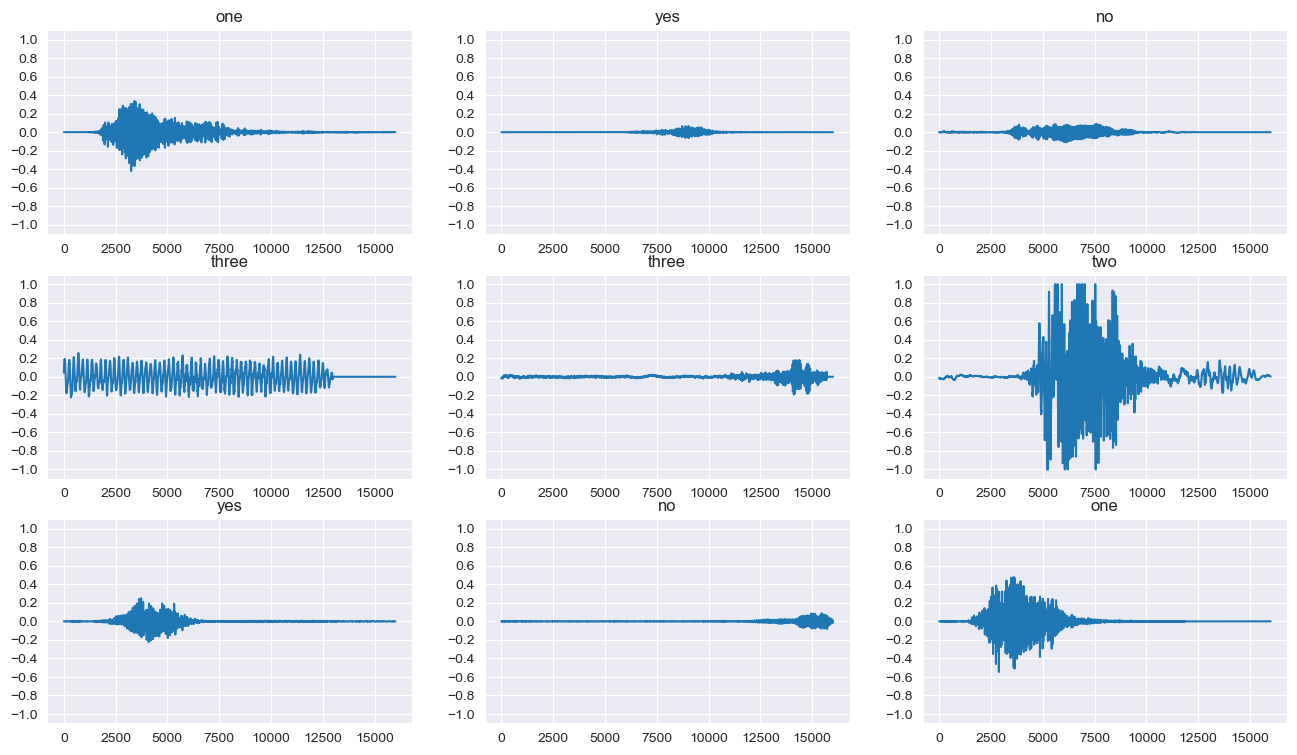

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

## waveforms to spectrograms




I'm using this function to convert the av file to a spectrogram then I will be using this later

In [20]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [21]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: one
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


function for displaying a spectrogram:

In [22]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

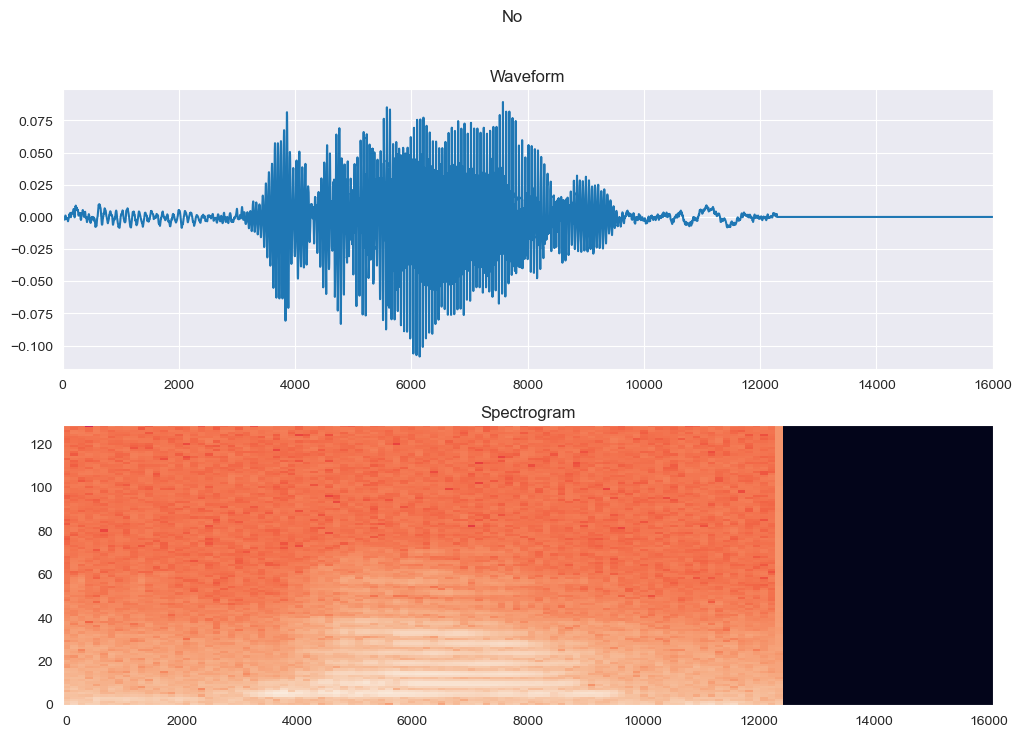

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, creating spectrogramn datasets from the audio datasets:

In [24]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [26]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

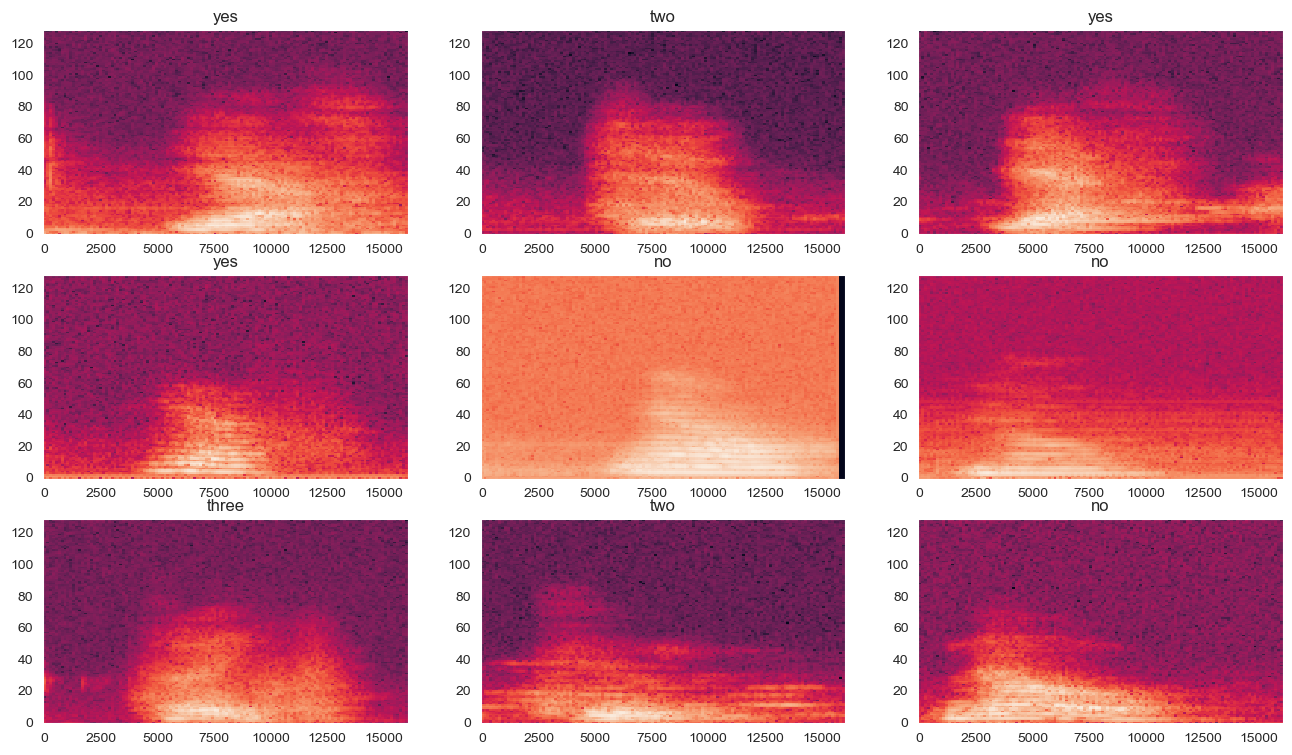

In [27]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [28]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, I will use a simple convolutional neural network (CNN), since I have transformed the audio files into spectrogram images.

My `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster. (I will downsample to 16000)
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [29]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 25 epochs for demonstration purposes:

In [31]:
EPOCHS = 25
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
244/244 [==============================] - 22s 86ms/step - loss: 1.0317 - accuracy: 0.5909 - val_loss: 0.5438 - val_accuracy: 0.8193
Epoch 2/10
244/244 [==============================] - 18s 72ms/step - loss: 0.5408 - accuracy: 0.8052 - val_loss: 0.3460 - val_accuracy: 0.8880
Epoch 3/10
244/244 [==============================] - 18s 72ms/step - loss: 0.3991 - accuracy: 0.8615 - val_loss: 0.2776 - val_accuracy: 0.9094
Epoch 4/10
244/244 [==============================] - 18s 75ms/step - loss: 0.3333 - accuracy: 0.8827 - val_loss: 0.2620 - val_accuracy: 0.9125
Epoch 5/10
244/244 [==============================] - 18s 75ms/step - loss: 0.2977 - accuracy: 0.8979 - val_loss: 0.2452 - val_accuracy: 0.9125
Epoch 6/10
244/244 [==============================] - 18s 72ms/step - loss: 0.2724 - accuracy: 0.9075 - val_loss: 0.2304 - val_accuracy: 0.9255
Epoch 7/10
244/244 [==============================] - 18s 72ms/step - loss: 0.2490 - accuracy: 0.9124 - val_loss: 0.2304 - val_accuracy:

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

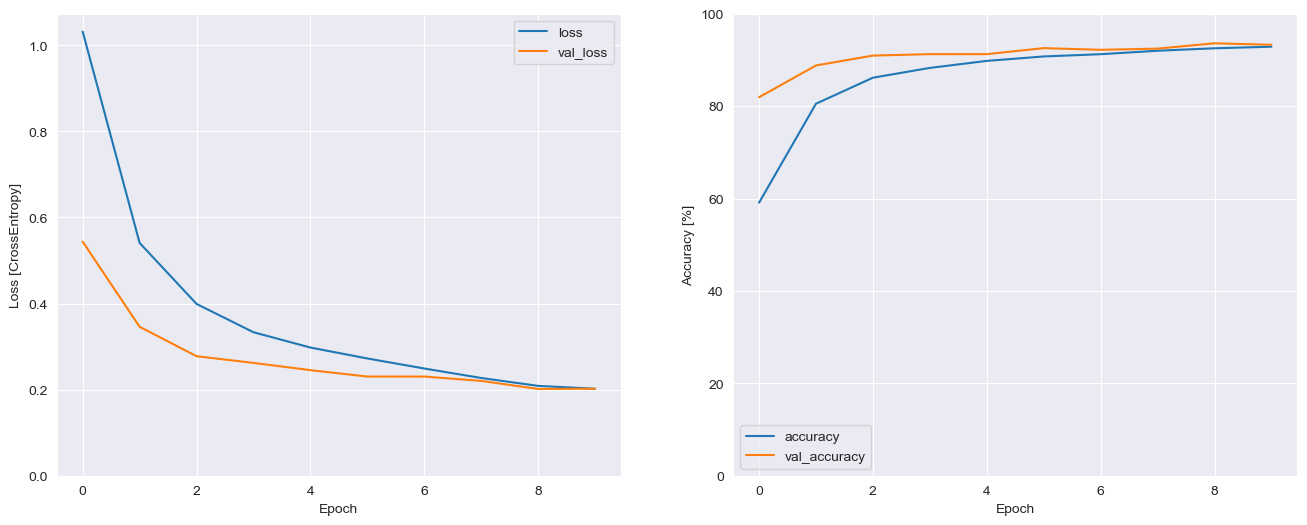

In [32]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

 Evaluate the model performance

Run the model on the test set and check the model's performance:

In [33]:
model.evaluate(test_spectrogram_ds, return_dict=True)

31/31 [==============================] - 1s 38ms/step - loss: 0.2496 - accuracy: 0.9155


{'loss': 0.24955962598323822, 'accuracy': 0.9155285954475403}

Display a confusion matrix to check how well the model did classifying each of the commands in the test set:


In [34]:
y_pred = model.predict(test_spectrogram_ds)

31/31 [==============================] - 0s 14ms/step


In [35]:
y_pred = tf.argmax(y_pred, axis=1)

In [36]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

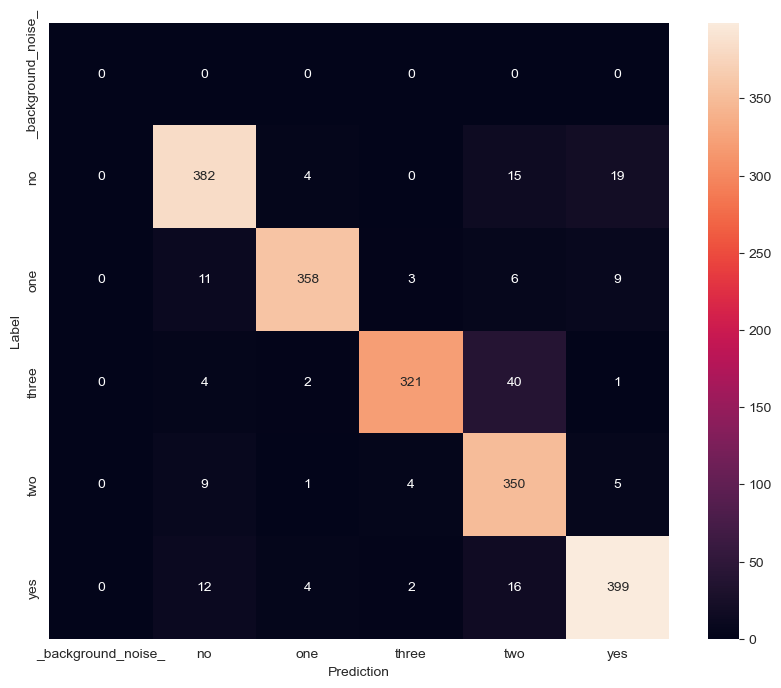

In [37]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()



Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

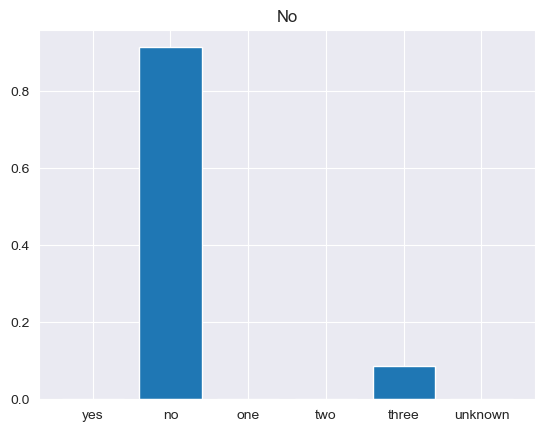

In [38]:
x = 'C:/Users/Yasiru/Downloads/tensorflow/data_speech_commands/no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_labels = ['yes', 'no', 'one', 'two', 'three']
num_classes = model.output_shape[-1]
if num_classes > len(x_labels):
    x_labels += ['unknown'] * (num_classes - len(x_labels))
elif num_classes < len(x_labels):
    x_labels = x_labels[:num_classes]

prediction = model(x)
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

As the output suggests, your model should have recognized the audio command as "no".

Export the model as a savedModel and a TFLITE model for android

Exporting with preprocessed savedModel

In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Define the input signature
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

        # Define the output signature
        self.signature = (
            tf.TensorSpec(shape=(None, 5), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int64),
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        )

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 16000], dtype=tf.float32)])
    def __call__(self, x):
        # If they pass a string, load the file and decode it.
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)

        return result, class_ids, class_names

Test run the "export" model:

In [41]:
import tensorflow as tf

# Export the model to a SavedModel format
tf.saved_model.save(model, 'savedTest')

# Convert the SavedModel to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model('savedTest')
tflite_model = converter.convert()

# Save the converted model to a file
with open('savedLiteTest/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: savedTest\assets


INFO:tensorflow:Assets written to: savedTest\assets


In [ ]:
export = ExportModel(model)
export(tf.constant(str('C:/Users/Yasiru/Downloads/tensorflow/data_speech_commands/no/01bb6a2a_nohash_0.wav')))

Save and reload the model, the reloaded model gives identical output: